<a href="https://colab.research.google.com/github/eduion/DeepRL/blob/main/HW4/HW4_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# 1. 下載並使用外部 Gridworld.py 和 GridBoard.py
# 請將下列 URL 換成 raw 檔案的連結
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py

In [3]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 49.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [16]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import pytorch_lightning as pl
from Gridworld import Gridworld
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import Trainer

move_pos = [(-1, 0), (1, 0), (0, -1), (0, 1)]
action_set = ['up', 'down', 'left', 'right']

class DQNLightning(pl.LightningModule):
    def __init__(self, lr=1e-3, gamma=0.9, mem_size=1000, batch_size=200, epochs=500):
        super().__init__()
        self.save_hyperparameters()
        L1, L2, L3, L4, L5 = 64, 128, 256, 128, 4
        self.model = torch.nn.Sequential(
            torch.nn.Linear(L1, L2),
            torch.nn.ReLU(),
            torch.nn.Linear(L2, L3),
            torch.nn.ReLU(),
            torch.nn.Linear(L3, L4),
            torch.nn.ReLU(),
            torch.nn.Linear(L4, L5)
        )
        self.loss_fn = torch.nn.MSELoss()
        self.gamma = gamma
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.epochs = epochs
        self.replay = deque(maxlen=mem_size)
        self.epsilon = 1.0
        self.max_moves = 50
        self.losses = []

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=self.hparams.epochs * 4 // 5,
            gamma=0.5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            }
        }

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        device = self.device
        game = Gridworld(size=4, mode='random')
        state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/100.0
        state1 = torch.from_numpy(state1_).float().to(device)
        status = 1
        mov = 0
        while status == 1:
            mov += 1
            qval = self(state1)
            qval_ = qval.data.cpu().numpy()
            if random.random() < self.epsilon:
                action_ = np.random.randint(0, 4)
            else:
                action_ = np.argmax(qval_)
            hit_wall = game.validateMove('Player', move_pos[action_]) == 1
            action = action_set[action_]
            game.makeMove(action)
            state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/100.0
            state2 = torch.from_numpy(state2_).float().to(device)
            reward = -5 if hit_wall else game.reward()
            done = True if reward != -1 else False
            exp = (state1, action_, reward, state2, done)
            self.replay.append(exp)
            state1 = state2
            if abs(reward) == 10 or mov > self.max_moves:
                status = 0
                mov = 0

        if len(self.replay) > self.batch_size:
            minibatch = random.sample(self.replay, self.batch_size)
            state1_batch = torch.cat([s1.to(device) for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.tensor([a for (s1,a,r,s2,d) in minibatch], device=device)
            reward_batch = torch.tensor([r for (s1,a,r,s2,d) in minibatch], dtype=torch.float32, device=device)
            state2_batch = torch.cat([s2.to(device) for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.tensor([d for (s1,a,r,s2,d) in minibatch], dtype=torch.float32, device=device)
            Q1 = self(state1_batch)
            with torch.no_grad():
                Q2 = self(state2_batch)
            Y = reward_batch + self.gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = self.loss_fn(X, Y.detach())
            self.losses.append(loss.item())
            if self.epsilon > 0.1:
                self.epsilon -= (1/self.epochs)
            self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
            return loss
        else:
            return None

    def train_dataloader(self):
        dummy = torch.zeros(1)
        return DataLoader(TensorDataset(dummy), batch_size=1)



if __name__ == "__main__":
    model = DQNLightning()
    trainer = Trainer(max_epochs=500, log_every_n_steps=1)
    trainer.fit(model)


INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 74.8 K | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
74.8 K    Trainable params
0         Non-trainable params
74.8 K    Total params
0.299     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


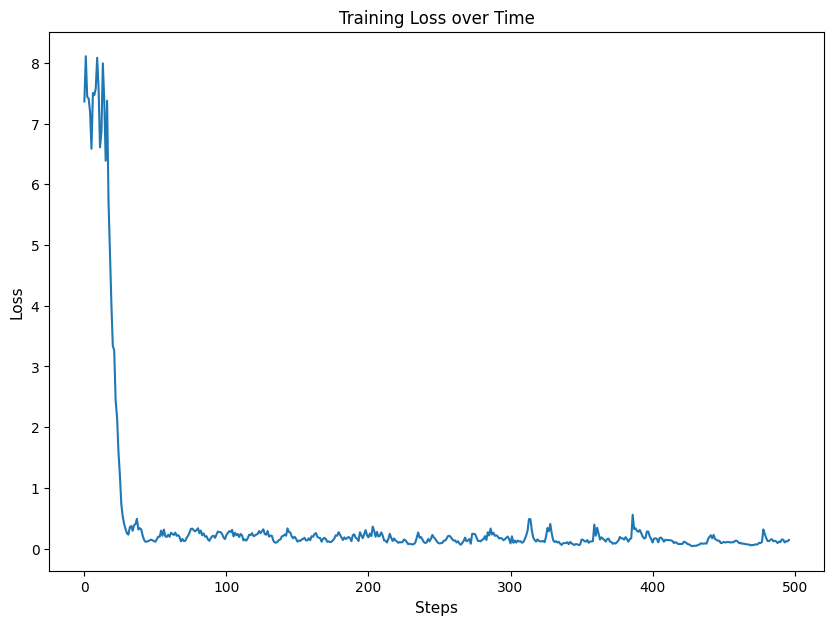

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(model.losses)
plt.xlabel("Steps", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.title("Training Loss over Time")
plt.show()